In [7]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-11,11),p=0.5),
        albu.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.4),
        #albu.GaussNoise(p=0.2),
        #albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        #albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(128, 128)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None, training=True):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)

    train_slice = int(len(self.image_ids)*0.2)

    if training == True:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][train_slice::]
      self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.image_ids][train_slice::]
    else:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][:train_slice]
      self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.image_ids][:train_slice]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

    sample = self.augmentation(image=image, mask=mask)
    image, mask = sample['image'], sample['mask']

    image = torch.tensor(image)

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11).float()

    return (image.permute(2,0,1).float(), one_hot_Y.permute(2,0,1).float())


train_x_path = "/home/nathan/Documents/final_project/datasets/label_adapter_helen_train/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/label_adapter_helen_train/masks"

val_x_path = train_x_path
val_y_path = train_y_path

train_ds2 = MyDataSet(train_x_path, train_y_path, None, augmentation=get_training_augmentation())
val_ds2 = MyDataSet(val_x_path, val_y_path, None, training=False, augmentation=get_validation_augmentation())


In [8]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader2 = DataLoader(train_ds2, batch_size=24, shuffle=True, num_workers=7)
valid_loader2 = DataLoader(val_ds2, batch_size=24, shuffle=False, num_workers=7)
print(len(train_loader2))
print(len(valid_loader2))

124
31


In [9]:
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, lraspp_mobilenet_v3_large, deeplabv3_resnet101

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
#CLASSES = ["background", "skin", "nose", "right_eye", "left_eye", "right_brow", "left_brow", "right_ear", "left_ear", "mouth_interior", "top_lip", "bottom_lip", "neck", "hair", "beard", "clothing", "glasses", "headwear", "facewear"]
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 11

"""
aux_params=dict(
    pooling='avg',       # one of 'avg', 'max'
    classes=num_classes, 
    activation = None
)
"""

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [10]:
from segmentation_models_pytorch import utils
import os

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
#"cuda" if torch.cuda.is_available() else
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loss = smp.utils.losses.BCELoss()
#loss = FocalLoss("multilabel", alpha=0.25, gamma=4)
#weights = torch.tensor([0.7526, 0.4953, 0.9898, 0.9910, 0.9942, 0.9942, 0.9579, 0.9940, 0.9931,
#        0.9895, 0.8484])

#loss = SoftBCEWithLogitsLoss(pos_weight=normedWeights)
loss = smp.utils.losses.CrossEntropyLoss()

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


In [11]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    #optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            v_ious.append(valid_logs['iou_score'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()



Epoch: 1
valid: 100%|██████████| 31/31 [00:03<00:00,  9.53it/s, cross_entropy_loss - 1.731, iou_score - 0.4988]
Model saved!

Epoch: 2
valid: 100%|██████████| 31/31 [00:02<00:00, 11.30it/s, cross_entropy_loss - 1.685, iou_score - 0.5874]
Model saved!


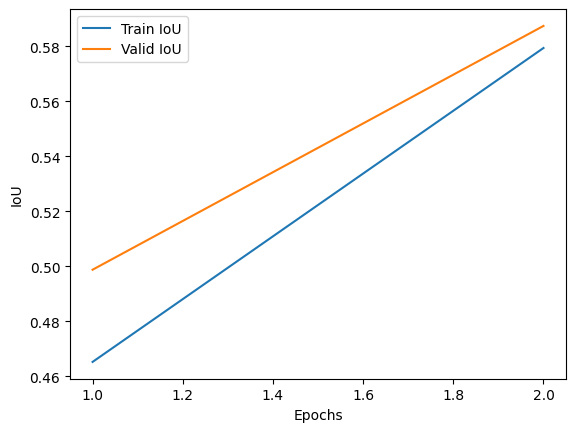


Epoch: 3
valid: 100%|██████████| 31/31 [00:02<00:00, 11.33it/s, cross_entropy_loss - 1.663, iou_score - 0.6237]
Model saved!

Epoch: 4
valid: 100%|██████████| 31/31 [00:02<00:00, 11.46it/s, cross_entropy_loss - 1.668, iou_score - 0.6102]


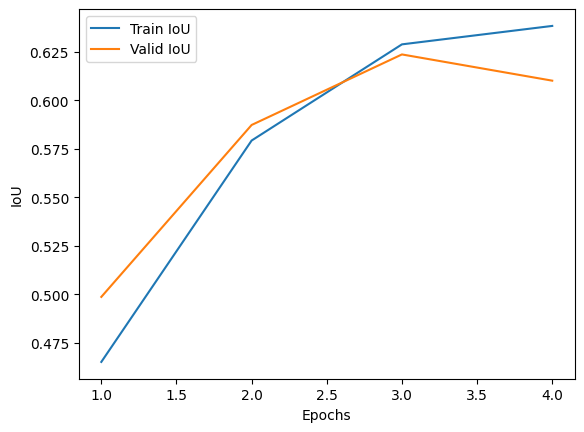


Epoch: 5
valid: 100%|██████████| 31/31 [00:02<00:00, 11.51it/s, cross_entropy_loss - 1.718, iou_score - 0.5404]

Epoch: 6
valid: 100%|██████████| 31/31 [00:02<00:00, 11.38it/s, cross_entropy_loss - 1.651, iou_score - 0.656] 
Model saved!


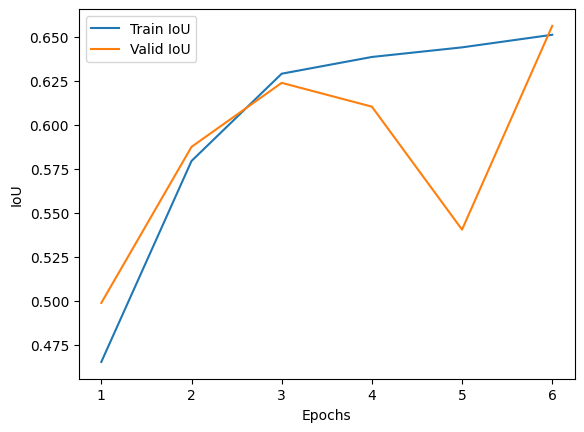


Epoch: 7
valid: 100%|██████████| 31/31 [00:02<00:00, 11.54it/s, cross_entropy_loss - 1.719, iou_score - 0.5177]

Epoch: 8
valid: 100%|██████████| 31/31 [00:03<00:00,  9.08it/s, cross_entropy_loss - 1.648, iou_score - 0.6449]


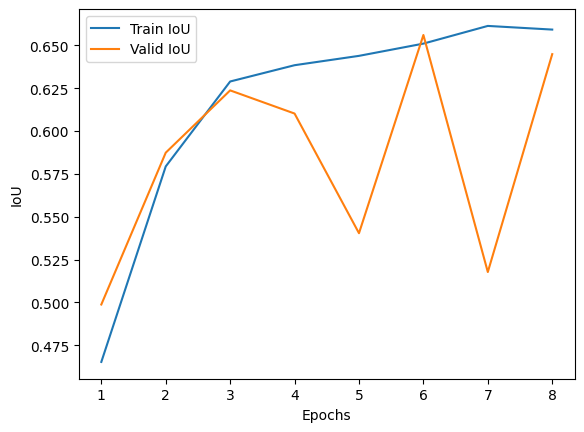


Epoch: 9
valid: 100%|██████████| 31/31 [00:03<00:00,  9.76it/s, cross_entropy_loss - 1.652, iou_score - 0.64]  

Epoch: 10
valid: 100%|██████████| 31/31 [00:03<00:00,  9.71it/s, cross_entropy_loss - 1.668, iou_score - 0.6122]


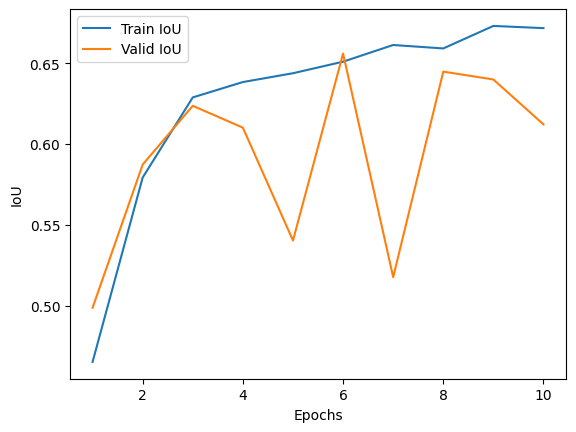


Epoch: 11
valid: 100%|██████████| 31/31 [00:03<00:00,  9.83it/s, cross_entropy_loss - 1.641, iou_score - 0.6736]
Model saved!

Epoch: 12
valid: 100%|██████████| 31/31 [00:03<00:00,  9.64it/s, cross_entropy_loss - 1.644, iou_score - 0.6413]


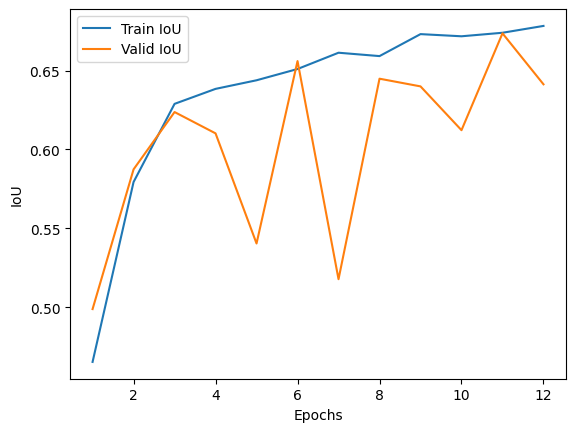


Epoch: 13
valid: 100%|██████████| 31/31 [00:03<00:00,  9.10it/s, cross_entropy_loss - 1.642, iou_score - 0.6677]

Epoch: 14
valid: 100%|██████████| 31/31 [00:03<00:00,  9.62it/s, cross_entropy_loss - 1.641, iou_score - 0.6509]


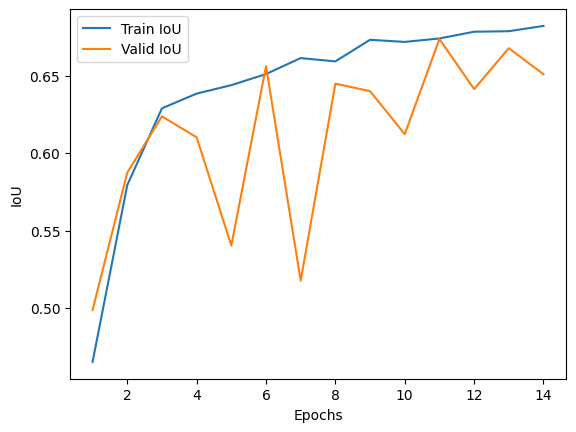


Epoch: 15
valid: 100%|██████████| 31/31 [00:03<00:00,  9.19it/s, cross_entropy_loss - 1.641, iou_score - 0.6708]

Epoch: 16
valid: 100%|██████████| 31/31 [00:03<00:00,  9.53it/s, cross_entropy_loss - 1.642, iou_score - 0.6501]


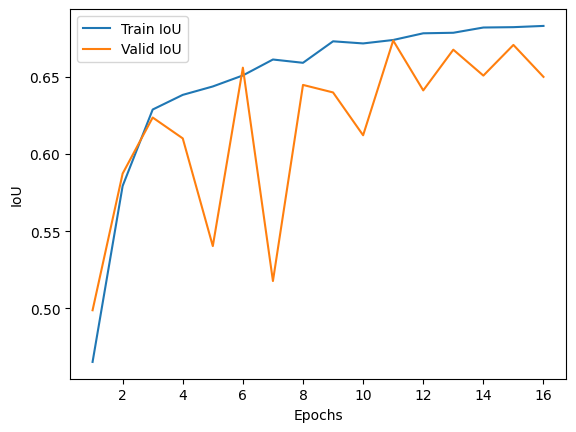


Epoch: 17
valid: 100%|██████████| 31/31 [00:02<00:00, 10.41it/s, cross_entropy_loss - 1.642, iou_score - 0.6548]

Epoch: 18
valid: 100%|██████████| 31/31 [00:03<00:00, 10.25it/s, cross_entropy_loss - 1.645, iou_score - 0.6505]


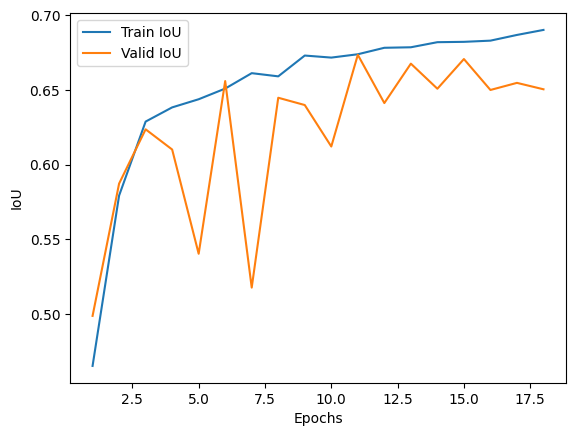


Epoch: 19
valid: 100%|██████████| 31/31 [00:03<00:00,  9.82it/s, cross_entropy_loss - 1.645, iou_score - 0.6657]

Epoch: 20
valid: 100%|██████████| 31/31 [00:02<00:00, 11.48it/s, cross_entropy_loss - 1.639, iou_score - 0.6625]


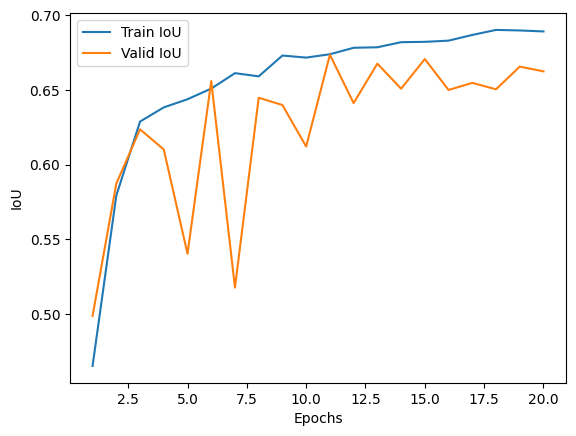


Epoch: 21
valid: 100%|██████████| 31/31 [00:02<00:00, 11.03it/s, cross_entropy_loss - 1.645, iou_score - 0.6547]

Epoch: 22
train:  12%|█▏        | 15/124 [00:04<00:31,  3.44it/s, cross_entropy_loss - 1.632, iou_score - 0.6839]


KeyboardInterrupt: 

In [12]:
train_model(mobile, train_loader2, valid_loader2, "/home/nathan/Documents/final_project/saved_models/label_adapted_helen.pth", 50)

In [ ]:
import label_test_script

rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10,11]

model = torch.load("/home/nathan/Documents/final_project/saved_models/label_adapted_lapa.pth", map_location=DEVICE)

view_label_predictions(model,val_ds2, num_classes)